___
### Notebook 4 - Machine Learning Models - Clustering and Classification
___

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
# Clearing up memory
import gc

# Featuretools for automated feature engineering
import featuretools as ft
ft.__version__

'0.2.1'

# Clustering

In [3]:
df_kaggle = pd.read_csv('Cleaned_Application_Data.csv')
feature_matrix = pd.read_csv('feature_matrix.csv')
cols_df_kaggle = df_kaggle.columns
cols_df_kaggle = cols_df_kaggle.drop('SK_ID_CURR')
cols_feature_matrix = feature_matrix.columns
cols_common = list(set(cols_df_kaggle).intersection(cols_feature_matrix))
# Remove the columns from feature_matrix dataset that are present in both the datasets 
feature_matrix.drop(cols_common, axis=1, inplace=True)

In [4]:
print("Feature Matrix Shape:", feature_matrix.shape)
desc = feature_matrix.describe(include='all').T
desc['percent_missing'] = (feature_matrix['SK_ID_CURR'].size - desc['count'])*100/feature_matrix['SK_ID_CURR'].size
desc = desc[desc['count']<feature_matrix['SK_ID_CURR'].size][['count','percent_missing']]
print("Cleaned_Application_Data has {} columns with missing data out of total {} columns".format(desc.shape[0], 
      feature_matrix.columns.size))

Feature Matrix Shape: (356255, 458)
Cleaned_Application_Data has 451 columns with missing data out of total 458 columns


In [5]:
feature_matrix['missing_columns'] = feature_matrix.isnull().sum(axis=1)
feature_matrix['missing_columns'] = pd.Categorical(feature_matrix['missing_columns'], 
            feature_matrix['missing_columns'].unique())
feature_matrix.fillna(0, inplace=True)
print("feature_matrix shape before one hot:", feature_matrix.shape)
feature_matrix = pd.get_dummies(feature_matrix)
print("feature_matrix shape after one hot:", feature_matrix.shape)

feature_matrix shape before one hot: (356255, 459)
feature_matrix shape after one hot: (356255, 641)


In [37]:
from sklearn.preprocessing import StandardScaler
feature_matrix_std = StandardScaler().fit_transform(feature_matrix.drop('SK_ID_CURR', axis=1))
feature_matrix_std = pd.DataFrame(feature_matrix_std)

In [38]:
feature_samp = feature_matrix_std.sample(frac=0.2)

MemoryError: 

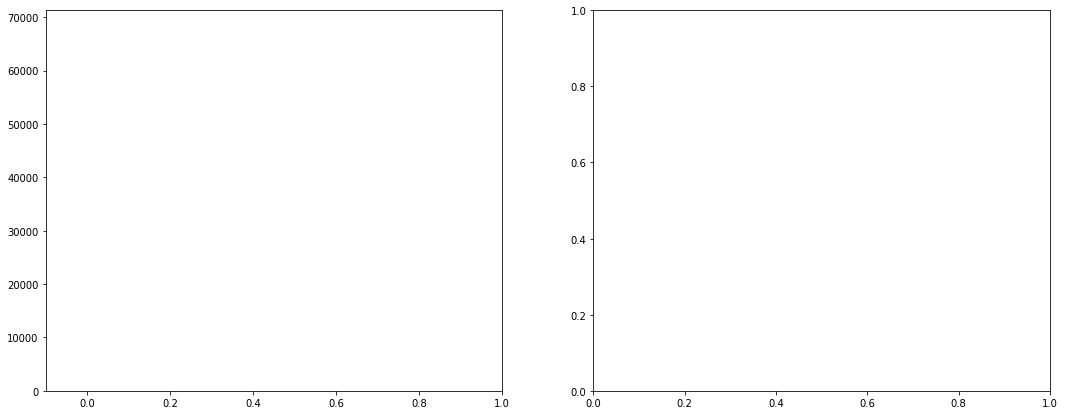

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


range_n_clusters = [3, 4, 5, 8, 10, 12]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(feature_samp) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(feature_samp)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(feature_samp, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(feature_samp, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.subtitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

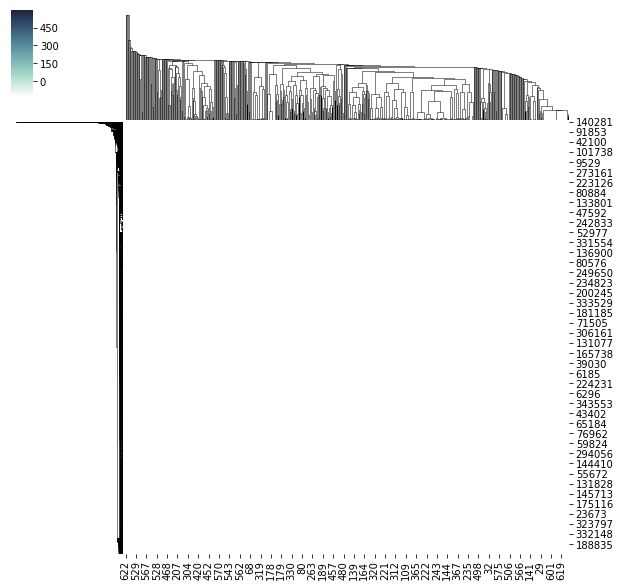

In [8]:
import seaborn as sns
cmap = sns.cubehelix_palette(as_cmap=True, rot=-.3, light=1)
sns.clustermap(feature_samp, cmap=cmap, linewidths=.5)

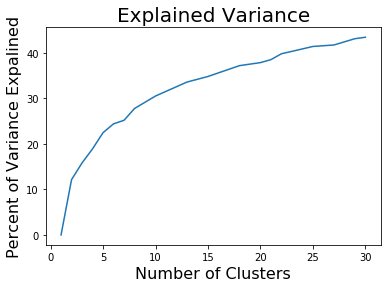

In [39]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist

cluster_range = [ 1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 15, 18, 20, 21, 22,  23, 25, 27, 29, 30]
cluster_errors = []


kMeansVar = [KMeans(n_clusters=k).fit(feature_samp) for k in cluster_range]
centroids = [X.cluster_centers_ for X in kMeansVar]
cluster_errors = [X.inertia_ for X in kMeansVar]
k_euclid = [cdist(feature_samp, cent) for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]
wcss = [sum(d**2) for d in dist]
tss = sum(pdist(feature_samp)**2)/feature_samp.shape[0]
bss = tss - wcss
plt.plot(cluster_range, bss/tss*100)
plt.title('Explained Variance', fontsize=20)
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('Percent of Variance Expalined', fontsize=16)
plt.show()

Text(0,0.5,'Error')

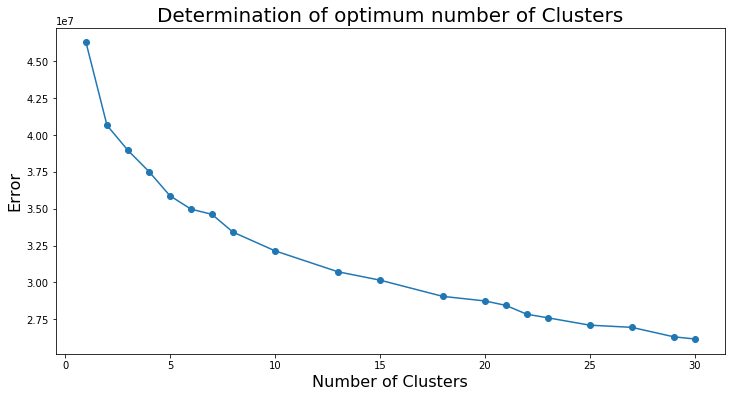

In [40]:
clusters_df  = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.title('Determination of optimum number of Clusters', fontsize=20)
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('Error', fontsize=16)

In [116]:
kmean_model = kMeansVar[5]
kmean_model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [117]:
feature_cluster = pd.DataFrame(kmean_model.transform(feature_matrix_std))
feature_cluster = pd.DataFrame(StandardScaler().fit_transform(feature_cluster))
feature_cluster.head()

,0,1,2,3,4,5
0,-0.144234,-0.214580,-0.040748,0.056110,-0.483150,-0.016562
1,-0.395535,-0.353617,-0.157497,-0.073169,-0.514877,-0.029724
2,-0.093768,0.114483,0.097141,0.122834,0.066204,0.009266
3,-0.206876,-0.338917,-0.050434,0.003818,-0.652830,-0.024336
4,-0.321864,-0.419776,-0.125035,-0.056546,-0.728525,-0.030525


In [51]:
print(feature_matrix_std.join(feature_cluster, rsuffix='_cluster').shape, feature_matrix_std.shape, feature_cluster.shape)

(356255, 646) (356255, 640) (356255, 6)


In [119]:
feature_clustered_matrix = pd.DataFrame(feature_matrix['SK_ID_CURR']).join(feature_cluster)
feature_clustered_matrix.head()

,SK_ID_CURR,0,1,2,3,4,5
0,100001,-0.144234,-0.214580,-0.040748,0.056110,-0.483150,-0.016562
1,100002,-0.395535,-0.353617,-0.157497,-0.073169,-0.514877,-0.029724
2,100003,-0.093768,0.114483,0.097141,0.122834,0.066204,0.009266
3,100004,-0.206876,-0.338917,-0.050434,0.003818,-0.652830,-0.024336
4,100005,-0.321864,-0.419776,-0.125035,-0.056546,-0.728525,-0.030525


In [120]:
print("Shape before scaling", df_kaggle.shape)
df_kaggle_std = pd.DataFrame(StandardScaler().fit_transform(pd.get_dummies(df_kaggle.drop(['SK_ID_CURR', 'TARGET'], 
                                    axis=1)).values))
print("Shape after scaling", df_kaggle_std.shape)
df_kaggle_std = df_kaggle_std.join(df_kaggle[['SK_ID_CURR', 'TARGET']])
print("Shape after scaling with SK_ID and TARGET fields:", df_kaggle_std.shape)
df_kaggle_std = df_kaggle_std.merge(feature_clustered_matrix, on='SK_ID_CURR', how='outer', suffixes=('','_cluster'))
print("Shape after joining with feature_cluster_matrix dataset:", df_kaggle_std.shape)
df_kaggle_std = df_kaggle_std[df_kaggle_std.TARGET != -1] # 
print('Shape after droping the Kaggle test data records', df_kaggle_std.shape)

Shape before scaling (356255, 127)
Shape after scaling (356255, 257)
Shape after scaling with SK_ID and TARGET fields: (356255, 259)
Shape after joining with feature_cluster_matrix dataset: (356255, 265)
Shape after droping the Kaggle test data records (307511, 265)


In [121]:
df_kaggle_std.head()

,0,1,2,3,4,5,6,7,8,9,...,255,256,SK_ID_CURR,TARGET,0_cluster,1_cluster,2_cluster,3_cluster,4_cluster,5_cluster
0,-0.575137,0.144890,-0.454489,-0.184755,-0.482247,-0.152069,1.509648,0.634953,0.378681,0.581113,...,-0.392553,0.392553,100002,1,-0.395535,-0.353617,-0.157497,-0.073169,-0.514877,-0.029724
1,-0.575137,0.446895,1.770432,0.561651,1.643532,-1.248730,-0.166044,0.580295,1.076732,1.786068,...,-0.392553,0.392553,100003,0,-0.093768,0.114483,0.097141,0.122834,0.066204,0.009266
2,-0.575137,-0.459119,-1.135828,-1.403008,-1.072059,-0.782253,-0.689353,0.675822,0.205160,0.310344,...,-0.392553,0.392553,100004,0,-0.206876,-0.338917,-0.050434,0.003818,-0.652830,-0.024336
3,-0.575137,-0.157114,-0.690088,0.153632,-0.629700,-0.926918,-0.679947,0.396681,-1.374952,0.372272,...,2.547427,-2.547427,100006,0,0.002886,0.012529,0.166818,0.054766,0.253209,0.009099
4,-0.575137,-0.217515,-0.187564,-0.377159,-0.039889,0.556665,-0.892620,0.396781,0.190700,-0.300368,...,-0.392553,0.392553,100007,0,-0.684982,-0.448731,-0.308418,-0.155275,-0.468760,-0.021367


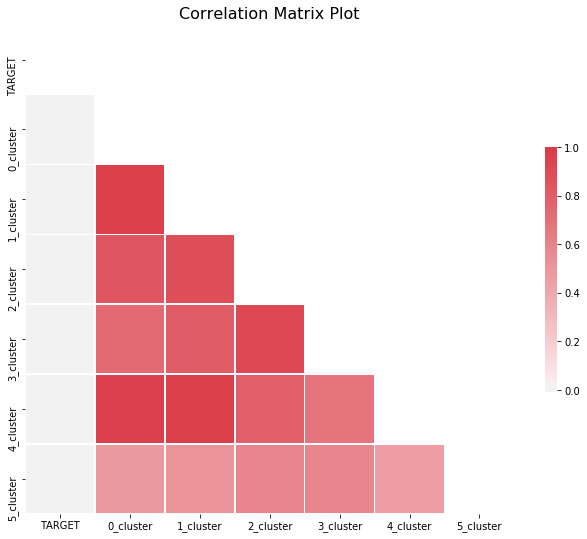

In [122]:
corr = df_kaggle_std[['TARGET',  '0_cluster', '1_cluster',  '2_cluster',  '3_cluster',  '4_cluster',  
    '5_cluster']].corr()

# plot correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation Matrix Plot", fontsize=16)
plt.show()

In [123]:
kmean_model = kMeansVar[5]
kmean_model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [124]:
predict_cluster = pd.DataFrame(kmean_model.predict(feature_matrix_std))
predict_cluster[0] = predict_cluster[0].astype('category')
predict_cluster = pd.get_dummies(predict_cluster)
predict_cluster.head(10)

,0_0,0_1,0_2,0_3,0_4,0_5
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,1,0,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,1,0
5,1,0,0,0,0,0
6,1,0,0,0,0,0
7,1,0,0,0,0,0
8,0,0,0,0,1,0
9,0,0,0,0,1,0


In [125]:
predict_clustered_matrix = pd.DataFrame(feature_matrix['SK_ID_CURR']).join(predict_cluster)
predict_clustered_matrix.head()

,SK_ID_CURR,0_0,0_1,0_2,0_3,0_4,0_5
0,100001,0,0,0,0,1,0
1,100002,0,0,0,0,1,0
2,100003,1,0,0,0,0,0
3,100004,0,0,0,0,1,0
4,100005,0,0,0,0,1,0


In [126]:
print("Shape before scaling", df_kaggle.shape)
df_kaggle_std = pd.DataFrame(StandardScaler().fit_transform(pd.get_dummies(df_kaggle.drop(['SK_ID_CURR', 'TARGET'], 
                                    axis=1)).values))
print("Shape after scaling", df_kaggle_std.shape)
df_kaggle_std = df_kaggle_std.join(df_kaggle[['SK_ID_CURR', 'TARGET']])
print("Shape after scaling with SK_ID and TARGET fields:", df_kaggle_std.shape)
df_kaggle_std = df_kaggle_std.merge(predict_clustered_matrix, on='SK_ID_CURR', how='outer', suffixes=('','_cluster'))
print("Shape after joining with predict_cluster_matrix dataset:", df_kaggle_std.shape)
df_kaggle_std = df_kaggle_std[df_kaggle_std.TARGET != -1] # 
print('Shape after droping the Kaggle test data records', df_kaggle_std.shape)
df_kaggle_std.head()

Shape before scaling (356255, 127)
Shape after scaling (356255, 257)
Shape after scaling with SK_ID and TARGET fields: (356255, 259)
Shape after joining with predict_cluster_matrix dataset: (356255, 265)
Shape after droping the Kaggle test data records (307511, 265)


,0,1,2,3,4,5,6,7,8,9,...,255,256,SK_ID_CURR,TARGET,0_0,0_1,0_2,0_3,0_4,0_5
0,-0.575137,0.144890,-0.454489,-0.184755,-0.482247,-0.152069,1.509648,0.634953,0.378681,0.581113,...,-0.392553,0.392553,100002,1,0,0,0,0,1,0
1,-0.575137,0.446895,1.770432,0.561651,1.643532,-1.248730,-0.166044,0.580295,1.076732,1.786068,...,-0.392553,0.392553,100003,0,1,0,0,0,0,0
2,-0.575137,-0.459119,-1.135828,-1.403008,-1.072059,-0.782253,-0.689353,0.675822,0.205160,0.310344,...,-0.392553,0.392553,100004,0,0,0,0,0,1,0
3,-0.575137,-0.157114,-0.690088,0.153632,-0.629700,-0.926918,-0.679947,0.396681,-1.374952,0.372272,...,2.547427,-2.547427,100006,0,1,0,0,0,0,0
4,-0.575137,-0.217515,-0.187564,-0.377159,-0.039889,0.556665,-0.892620,0.396781,0.190700,-0.300368,...,-0.392553,0.392553,100007,0,1,0,0,0,0,0


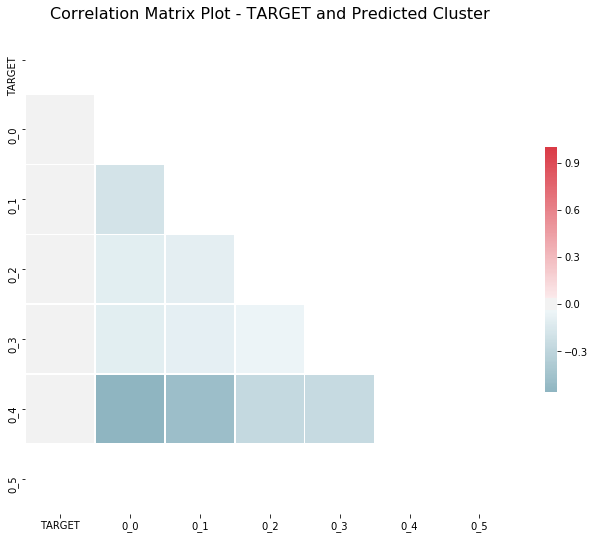

In [112]:
corr = df_kaggle_std[['TARGET', '0_0', '0_1', '0_2', '0_3', '0_4', '0_5']].corr()

# plot correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation Matrix Plot - TARGET and Predicted Cluster", fontsize=16)
plt.show()

# Classification evaluation function

In [108]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy
import pandas as pd
import itertools

def classification_evaluation(y_actual, y_prediction, y_prediction_prob, pr_roc_ind=1):
    """
    Implementation of classification_evaluation which is for implementaion of creation of confusion matrix and 
    ROC/PR curve.
        
    Arguments:
    y_actual -- Actual values of the variable to be predicted
    y_prediction -- Predicted values of the variable to be predicted
    y_prediction_prob -- Prediction probabilities with predicted values of the variable to be predicted
    pr_roc_ind -- Indicator to determine whether to create PR curve or ROC curve. If 1 then PR curve else ROC curve.
       
    Returns:
    """
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_actual, y_prediction)
    np.set_printoptions(precision=2)
    print("Detailed classification report:\n")
    print(classification_report(y_actual, y_prediction))
    print('Accuracy:', accuracy_score(y_actual, y_prediction))
    print('Weighted F1 score:', f1_score(y_actual, y_prediction, average='weighted'))
    
    fig, ax = plt.subplots(1,2, figsize=(14, 6))
    # Plot confusion matrix
    ax[0] = plot_confusion_matrix(cnf_matrix, classes=[0,1], threshold=0.5, plt_axis=ax[0])
    ax[0].set_title('Confusion Matrix')

    if pr_roc_ind==1:
        # calculate the fpr and tpr for all thresholds of the classification
        precision, recall, threshold = precision_recall_curve(y_actual, y_prediction_prob[:,1])
        # Plot PR Curve    
        ax[1] = plot_precision_recall_curve(precision, recall, plt_axis=ax[1])
        average_precision = average_precision_score(y_actual, y_prediction)
        ax[1].set_title("PR Curve:Average precision-recall score: {0:0.2f}".format(average_precision) )
    
    else:
        # calculate the fpr and tpr for all thresholds of the classification
        fpr, tpr, threshold = roc_curve(y_actual, y_prediction_prob[:,1])
        # Plot ROC Curve    
        ax[1] = plot_roc_curve(fpr, tpr, plt_axis=ax[1])
        ax[1].set_title("ROC Curve")
    
    plt.subplots_adjust( wspace=0.2)
    plt.show()
    
def plot_confusion_matrix(cm, classes, plt_axis, 
                          threshold = 0,
                          cmap=plt.cm.Blues ):
    """
    This function prints and plots the confusion matrix.
    """
    cm1 = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.sca(plt_axis)
    plt.imshow(cm1, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' 
    thresh = cm1.max() / 4 if threshold==0 else threshold
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt_axis.text(j, i, format(cm[i, j], fmt)+'\nNormalized:' + format(cm1[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm1[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt_axis

def plot_roc_curve(fpr, tpr, plt_axis):
    roc_auc = auc(fpr, tpr) # Area under curve
    plt.sca(plt_axis)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return plt_axis

def plot_precision_recall_curve(precision, recall, plt_axis):
    pr_auc = auc(recall, precision) # Area under curve
    plt.sca(plt_axis)
    plt.step(recall, precision, color='b', alpha=0.2, where='post', label = 'AUC = %0.2f' % pr_auc)
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.legend(loc = 'lower right')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    return plt_axis

# Perform Classification with clustering information

In [111]:
from sklearn.model_selection import StratifiedShuffleSplit
X = df_kaggle_std.drop(['SK_ID_CURR', 'TARGET'], axis=1).values
Y = df_kaggle_std['TARGET']
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
count = 1
print("")
for train_index, test_index in sss.split(X, Y):
    X_train = X[train_index]
    Y_train = Y[train_index]
    X_test = X[test_index]
    Y_test = Y[test_index]

from imblearn.over_sampling import SMOTE
sm = SMOTE( n_jobs=3)
x_train_res, y_train_res = sm.fit_sample(X_train, Y_train.ravel())

In [114]:
from collections import Counter
print(Counter(y_train_res).keys(), Counter(y_train_res).values())

dict_keys([0, 1]) dict_values([226148, 226148])


Random Forest Execution with clustered data: 
Detailed classification report:

             precision    recall  f1-score   support

          0       0.92      1.00      0.96     56538
          1       0.24      0.01      0.03      4965

avg / total       0.87      0.92      0.88     61503

Accuracy: 0.9168658439425719
Weighted F1 score: 0.8814491322104494


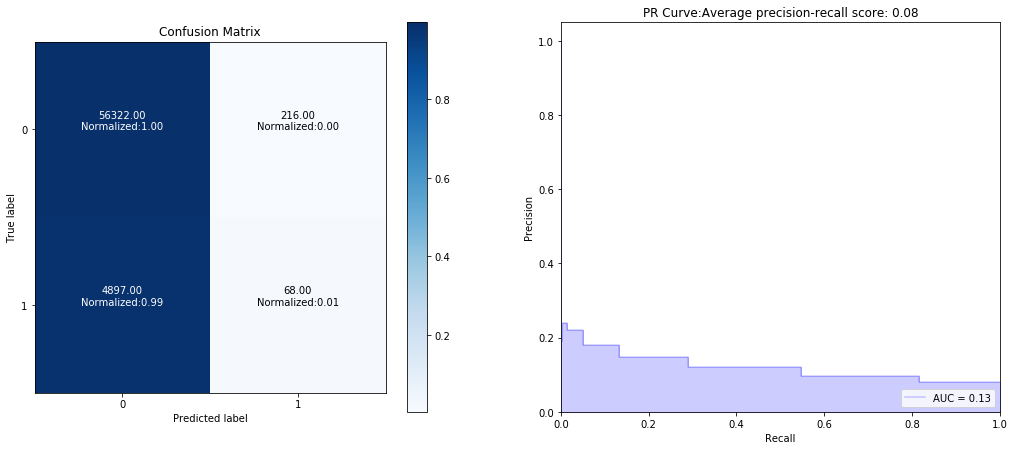

In [113]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(x_train_res, y_train_res.ravel())
y_pred = rfc.predict(X_test)
pred_prob = rfc.predict_proba(X_test)
print("Random Forest Execution with clustered data: ")
classification_evaluation(Y_test, y_pred, pred_prob)

Decision Tree Execution with clustered data: 
Detailed classification report:

             precision    recall  f1-score   support

          0       0.92      0.90      0.91     56538
          1       0.13      0.17      0.14      4965

avg / total       0.86      0.84      0.85     61503

Accuracy: 0.8421215225273564
Weighted F1 score: 0.8509937008719931


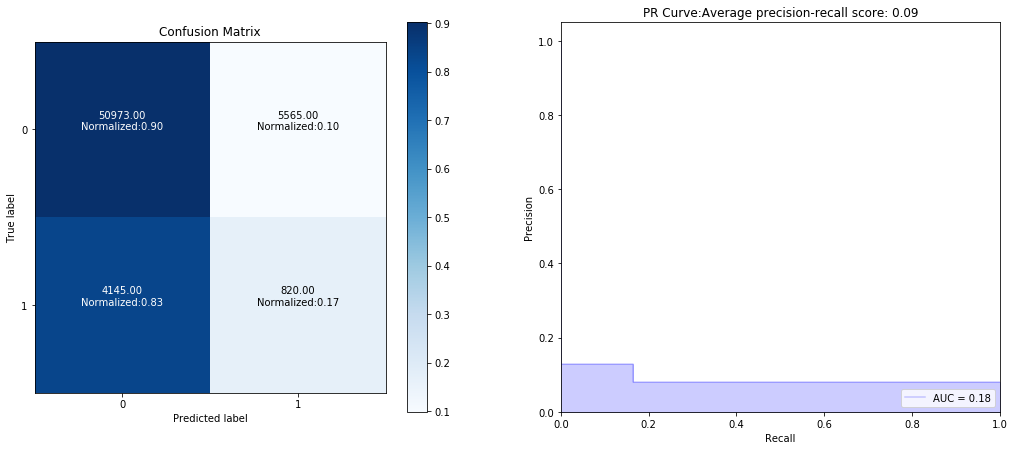

In [115]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train_res, y_train_res.ravel())
y_pred = dtc.predict(X_test)
pred_prob = dtc.predict_proba(X_test)
print("Decision Tree Execution with clustered data: ")
classification_evaluation(Y_test, y_pred, pred_prob)

In [127]:
feature_matrix_std = StandardScaler().fit_transform(feature_matrix.drop('SK_ID_CURR', axis=1))
feature_matrix_std = pd.DataFrame(feature_matrix_std)
feature_samp = feature_matrix_std.sample(frac=0.05)
print(feature_samp.shape)

(17813, 640)


In [130]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Compute DBSCAN
db = DBSCAN(eps=0.05, min_samples=10).fit(feature_samp)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(feature_samp, labels))

Estimated number of clusters: 1
Silhouette Coefficient: 0.010


In [133]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(damping=0.5).fit(feature_samp)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(feature_samp, labels, metric='sqeuclidean'))



Estimated number of clusters: 1538


In [134]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(damping=0.75).fit(feature_samp)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(feature_samp, labels, metric='sqeuclidean'))



Estimated number of clusters: 1408


In [138]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(damping=0.75, convergence_iter=5).fit(feature_samp)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(feature_samp, labels, metric='sqeuclidean'))



Estimated number of clusters: 1574


In [140]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(damping=0.75, convergence_iter=15, preference=-50).fit(feature_samp)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 10753


In [141]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(damping=0.75, convergence_iter=15, preference=50).fit(feature_samp)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 17813


In [139]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(damping=0.75, convergence_iter=50).fit(feature_samp)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(feature_samp, labels, metric='sqeuclidean'))



Estimated number of clusters: 1408
